<a href="https://colab.research.google.com/github/ruby199/Tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction


In [17]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-11-07 06:40:06.599109


In [18]:
# Are we using a GPU?
!nvidia-smi

Tue Nov  7 06:40:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   4903MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading and becoming one with the data

In [19]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-07 06:40:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 74.125.201.207, 74.125.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   204MB/s    in 0.8s    

2023-11-07 06:40:09 (204 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [20]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

###Creating data loaders (preparing the data

In [21]:
# Setip data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains


[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard).


In [22]:
# Create TensorBoard Callback (functionized because we need to create a new one for each model)
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")


Notebook last run (end-to-end): 2023-11-07 06:40:12.223389


In [23]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

> 🔑 **Note:** Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them.


## Creating models using Tensorflow hub

In the past, we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similarprocess, except the majority of our model's layer are going to come from [TensorFlow Hub](https://tfhub.dev/).


In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.


1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**.

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.


In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [25]:
# Let's compare the following two models

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [26]:
# Let's make  a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model


In [27]:
# Create REsnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [28]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [29]:
# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes). **Note:** The Image shows ResNet34 instead of ResNet50. **Image source:** https://arxiv.org/abs/1512.03385.*


In [30]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231107-064013
Epoch 1/5
24/24 [==============================] - 23s 746ms/step - loss: 1.9914 - accuracy: 0.3560 - val_loss: 1.2419 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 11s 454ms/step - loss: 0.9078 - accuracy: 0.7587 - val_loss: 0.8650 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 11s 460ms/step - loss: 0.6105 - accuracy: 0.8347 - val_loss: 0.7525 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 11s 463ms/step - loss: 0.4717 - accuracy: 0.8773 - val_loss: 0.7198 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 10s 442ms/step - loss: 0.3840 - accuracy: 0.9107 - val_loss: 0.6848 - val_accuracy: 0.7780


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**


In [32]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

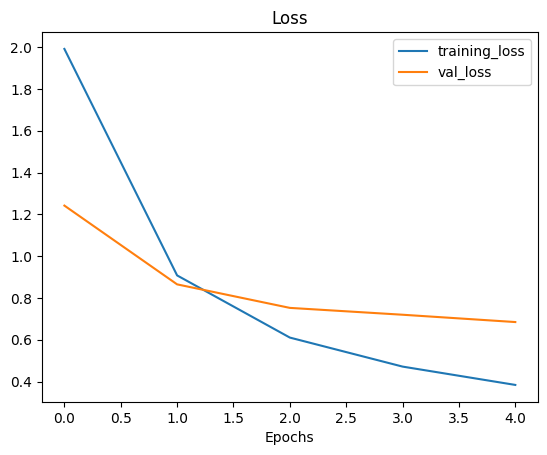

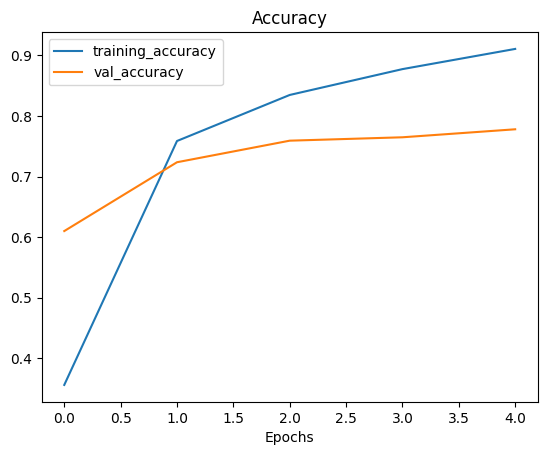

In [33]:
plot_loss_curves(resnet_history)

In [34]:
# Resnet summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the `model_url` parameter in the `create_model()` function and the `experiment_name` parameter in the `create_tensorboard_callback()` function.

In [35]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231107-064754
Epoch 1/5
24/24 [==============================] - 25s 565ms/step - loss: 1.7901 - accuracy: 0.4867 - val_loss: 1.2665 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 13s 539ms/step - loss: 1.0334 - accuracy: 0.7760 - val_loss: 0.8554 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 11s 467ms/step - loss: 0.7455 - accuracy: 0.8360 - val_loss: 0.6935 - val_accuracy: 0.8352
Epoch 4/5
24/24 [==============================] - 12s 535ms/step - loss: 0.6026 - accuracy: 0.8693 - val_loss: 0.6080 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 13s 537ms/step - loss: 0.5090 - accuracy: 0.8973 - val_loss: 0.5582 - val_accuracy: 0.8600


Holy smokes! The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again **with only 10% of the training data**.

How cool is that?

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

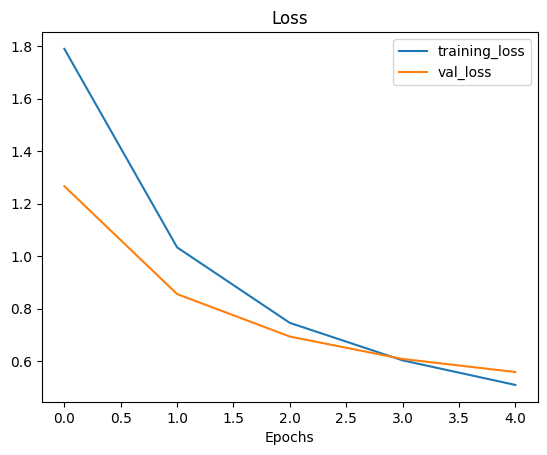

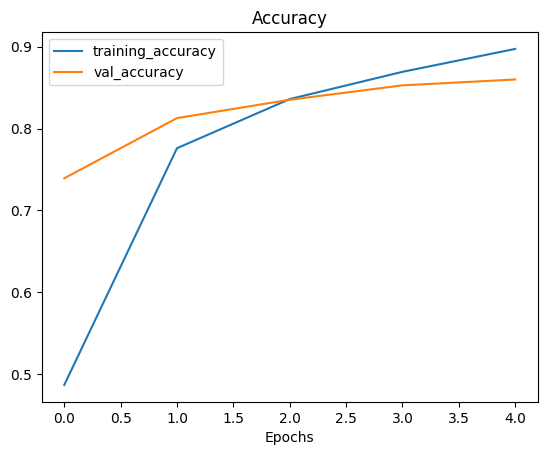

In [36]:
plot_loss_curves(efficientnet_history)

In [37]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

## Comparing models using TensorBoard

What if you had more than two models?

That's where an experiment tracking tool like [TensorBoard](https://www.tensorflow.org/tensorboard) (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to [TensorBoard.dev](https://tensorboard.dev/).

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.


# Upload TensorBoard dev records

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

```
Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot
```


Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description of the experiment
* `--one_shot` exits the TensorBoard uploader once uploading is finished

Running the `tensorboard dev upload` command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [40]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-11-07 06:59:34.660915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 06:59:34.660986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 06:59:34.661038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 06:59:35.765476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use 

Every time you upload something to TensorBoad.dev you'll get a new experiment ID. The experiment ID will look something like this: https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/ (this is the actual experiment from this notebook).

If you upload the same directory again, you'll get a new experiment ID to go along with it.

This means to track your experiments, you may want to look into how you name your uploads. That way when you find them on TensorBoard.dev you can tell what happened during each experiment (e.g. "efficientnet0_10_percent_data").

### Listing experiments you've saved to TensorBoard

To see all of the experiments you've uploaded you can use the command:

```tensorboard dev list```

In [41]:
# Check out experiments
# !tensorboard dev list # uncomment to see

2023-11-07 07:01:33.501298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 07:01:33.501382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 07:01:33.501435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 07:01:34.533998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev

In [42]:
# Delete an experiment
!tensorboard dev delete --experiment_id 7gBLpdbKS4OLj45Yigd7Mw

2023-11-07 07:03:26.975979: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 07:03:26.976046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 07:03:26.976097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 07:03:28.067767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev

In [43]:
# Check to see if experiments still exist
# !tensorboard dev list # uncomment to see

2023-11-07 07:03:42.347126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 07:03:42.347175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 07:03:42.347213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 07:03:43.347938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev